# Wireless Lab

## 1.0. Dependencies

In [101]:
import numpy as np
import matplotlib.pyplot as plt
import math
import sk_dsp_comm.fec_conv as fec

## 1.0. Debug functions

In [102]:
"""
Draw the power distribution graph
"""
def powerDistributionGraph(Z, title="", x_label="", y_label=""):
    fig, ax = plt.subplots()
    cs = ax.contourf(np.linspace(0, len(Z[0]), len(Z[0])), np.linspace(0, len(Z), len(Z)), np.absolute(Z))
    cbar = fig.colorbar(cs)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

## 1.1. Extraction of the time frequency matrix

Size of raw matrix:  (14, 1024)
Size of the matrix with only subcarriers:  (14, 624)
Size of the matrix with only subcarriers and useful channel:  (12, 624)


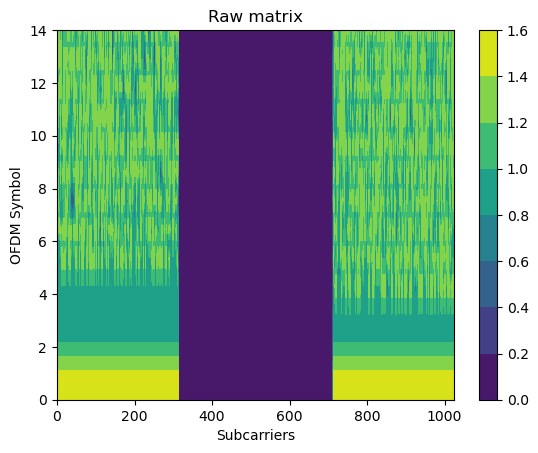

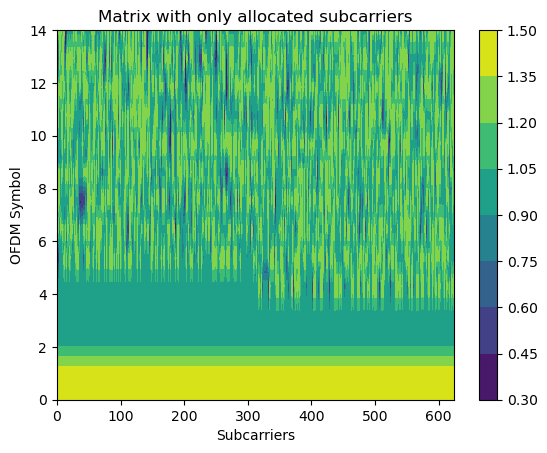

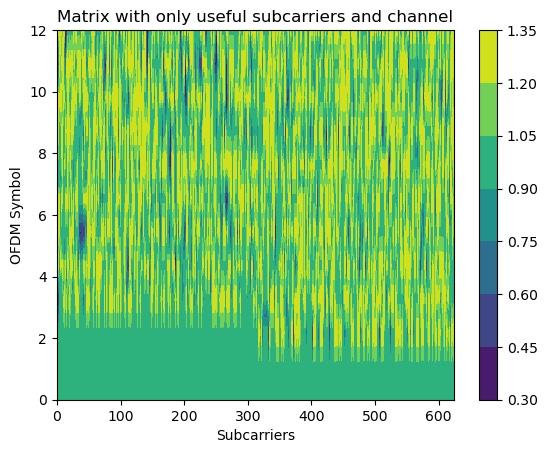

In [103]:
# Load raw matrix
data = np.genfromtxt('./data/tfMatrix.csv', delimiter=';')
tf_matrix = data[:,0::2] + 1j*data[:,1::2]

# Constants
N = 1024 # FFT size
NRe = 624 # Allocated subcarriers

# Print the size of the matrix
# Symbols per frame * FFT size
print("Size of raw matrix: ", tf_matrix.shape)
powerDistributionGraph(tf_matrix, title="Raw matrix", x_label="Subcarriers", y_label="OFDM Symbol")


# Recover only the useful part of the matrix
# 312 first subcarriers and 312 last subcarriers
tf_matrix_short =  np.concatenate([tf_matrix[:,1:NRe // 2 + 1], tf_matrix[:,-NRe // 2:]], axis=1)
print("Size of the matrix with only subcarriers: ", tf_matrix_short.shape)
powerDistributionGraph(tf_matrix_short, title="Matrix with only allocated subcarriers", x_label="Subcarriers", y_label="OFDM Symbol")


# Recover only the useful channel (PBCH, PDCCH, PDSCH)
# The two first OFDM symbols are used for synchronization and channel estimation
qam_matrix = tf_matrix_short[2:,:]
print("Size of the matrix with only subcarriers and useful channel: ", qam_matrix.shape)
powerDistributionGraph(qam_matrix, title="Matrix with only useful subcarriers and channel", x_label="Subcarriers", y_label="OFDM Symbol")

## 1.2. PBCH decoding
### 1.2.1. BPSK decoding

In [104]:
# 1. Check if BPSK symbols don't have imaginary parts
print("10 first symbols: ", qam_matrix[0,0:10])

# 2. Function to demodulates a BPSK stream into a binary stream
def bpsk_demod(bpsk_stream):
    return np.array([0 if symbol.real < 0 else 1 for symbol in bpsk_stream])

bit_seq = bpsk_demod(qam_matrix[0,0:10])
print("Binary conversion of 10 first symbols", bit_seq)

# Testing the demodulation
def test_bpsk():
    # BPSK decoding test
    np.testing.assert_array_equal(bpsk_demod(np.array([1.0+1j*0.0,1.0+1j*0.0,1.0+1j*0.0,-1.0+1j*0.0])), [1, 1, 1, 0])
    np.testing.assert_array_equal(bpsk_demod(np.array([1.0+1j*0.0,1.0+1j*0.0,-1.0+1j*0.0,1.0+1j*0.0,1.0+1j*0.0,1.0+1j*0.0,-1.0+1j*0.0,1.0+1j*0.0])), [1, 1, 0, 1, 1, 1, 0, 1])
    np.testing.assert_array_equal(bpsk_demod(np.array([1.0+1j*0.0,1.0+1j*0.0,1.0+1j*0.0,-1.0+1j*0.0,1.0+1j*0.0,1.0+1j*0.0,1.0+1j*0.0,-1.0+1j*0.0,-1.0+1j*0.0,-1.0+1j*0.0,1.0+1j*0.0,-1.0+1j*0.0,1.0+1j*0.0,-1.0+1j*0.0,1.0+1j*0.0,-1.0+1j*0.0])), [1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0])
    np.testing.assert_array_equal(bpsk_demod(np.array([-1.0+1j*0.0,-1.0+1j*0.0,-1.0+1j*0.0,-1.0+1j*0.0,-1.0+1j*0.0,-1.0+1j*0.0,1.0+1j*0.0,-1.0+1j*0.0,-1.0+1j*0.0,1.0+1j*0.0,1.0+1j*0.0,-1.0+1j*0.0,1.0+1j*0.0,-1.0+1j*0.0,-1.0+1j*0.0,-1.0+1j*0.0])), [0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0])
    np.testing.assert_array_equal(bpsk_demod(np.array([-1.2+1j*-0.2,-0.9+1j*-0.3,-1.1+1j*0.1,-1.0+1j*-0.0,-0.8+1j*0.2,-1.1+1j*-0.0,1.0+1j*0.2,-1.0+1j*0.0,-1.0+1j*0.1,1.2+1j*0.1,1.1+1j*-0.1,-1.0+1j*-0.1,1.1+1j*-0.1,-1.0+1j*0.2,-0.8+1j*-0.1,-1.0+1j*0.1])), [0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0])

test_bpsk()

# 3. Extract cells and users information
first_48_bytes = bpsk_demod(qam_matrix[0,0:48])

10 first symbols:  [-1.+0.j -1.+0.j -1.+0.j -1.+0.j -1.+0.j -1.+0.j -1.+0.j -1.+0.j  1.+0.j
  1.+0.j]
Binary conversion of 10 first symbols [0 0 0 0 0 0 0 0 1 1]


### 1.2.2. Hamming748 decoder

In [105]:
def hamming748_decode(bit_seq):
    if len(bit_seq) % 8 != 0:
        raise ValueError("The bit sequence length must be a multiple of 8")

    result = np.array([])

    H = np.matrix([
        [0, 0, 0, 1, 1, 1, 1],
        [0, 1, 1, 0, 0, 1, 1],
        [1, 0, 1, 0, 1, 0, 1]
    ])

    for i in range(len(bit_seq) // 8):
        y_748 = bit_seq[i*8:i*8+7]
        # Calculate syndrome (and convert to array)
        e = np.dot(H, y_748) % 2
        e = np.squeeze(np.asarray(e))

        # Calculate parity
        parity = np.sum(y_748) % 2

        if np.array_equal(e, [0, 0, 0]):
            result = np.concatenate((result, bit_seq[i*8:i*8+4]))
        elif parity == bit_seq[i*8+7]:
            # print("There are two errors")
            result = np.concatenate((result, [0, 0, 0, 0]))
        else:
            # Flip the bit that is incorrect
            n = bits_to_int(e) - 1
            bit_seq[i*8+n] = (bit_seq[i*8+n] - 1) % 2
            result = np.concatenate((result, bit_seq[i*8:i*8+4]))

    return result

# Array of bytes to int
def bits_to_int(bits):
    # Ensure bits is an array of ints
    bits = np.array(bits, dtype=int)
    return int("".join(map(str, bits)), 2)

def test_hammingDecode():
    # Decoding when no errors leads to sequence recovering
    np.testing.assert_array_equal(hamming748_decode([1, 1, 0, 1, 0, 0, 1, 0]), [1, 1, 0, 1])
    np.testing.assert_array_equal(hamming748_decode([1, 1, 0, 0, 1, 1, 0, 0]), [1, 1, 0, 0])
    np.testing.assert_array_equal(hamming748_decode([1, 1, 1, 1, 1, 1, 1, 1]), [1, 1, 1, 1])
    np.testing.assert_array_equal(hamming748_decode([0, 1, 1, 1, 1, 0, 0, 0]), [0, 1, 1, 1])
    np.testing.assert_array_equal(hamming748_decode([0, 1, 1, 0, 0, 1, 1, 0]), [0, 1, 1, 0])
    np.testing.assert_array_equal(hamming748_decode([0, 0, 1, 1, 0, 0, 1, 1]), [0, 0, 1, 1])
    np.testing.assert_array_equal(hamming748_decode([0, 0, 1, 0, 1, 1, 0, 1]), [0, 0, 1, 0])
    np.testing.assert_array_equal(hamming748_decode([0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1]), [0, 0, 1, 1, 0, 0, 1, 0])
    # # Ensure that one error is detected, and corrected
    np.testing.assert_array_equal(hamming748_decode([1, 1, 0, 1, 0, 0, 0, 0]), [1, 1, 0, 1])
    np.testing.assert_array_equal(hamming748_decode([1, 1, 0, 0, 1, 1, 0, 0]), [1, 1, 0, 0])
    np.testing.assert_array_equal(hamming748_decode([1, 0, 1, 1, 1, 1, 1, 1]), [1, 1, 1, 1])
    np.testing.assert_array_equal(hamming748_decode([0, 1, 1, 1, 1, 0, 0, 0]), [0, 1, 1, 1])
    np.testing.assert_array_equal(hamming748_decode([0, 1, 1, 0, 0, 1, 1, 0]), [0, 1, 1, 0])
    np.testing.assert_array_equal(hamming748_decode([0, 0, 1, 1, 0, 0, 1, 0]), [0, 0, 1, 1])
    np.testing.assert_array_equal(hamming748_decode([0, 0, 1, 0, 1, 1, 0, 1]), [0, 0, 1, 0])
    # # Ensure that two errors cannot be corrected
    np.not_equal(hamming748_decode([1, 0, 1, 1, 0, 0, 1, 0]), [1, 1, 0, 1])
    np.not_equal(hamming748_decode([1, 1, 1, 1, 1, 1, 0, 0]), [1, 1, 0, 0])
    np.not_equal(hamming748_decode([0, 1, 1, 0, 1, 1, 1, 1]), [1, 1, 1, 1])
    np.not_equal(hamming748_decode([1, 0, 1, 1, 1, 0, 0, 0]), [0, 1, 1, 1])
    np.not_equal(hamming748_decode([1, 1, 1, 1, 0, 1, 1, 0]), [0, 1, 1, 0])
    np.not_equal(hamming748_decode([0, 1, 0, 1, 0, 0, 1, 1]), [0, 0, 1, 1])
    np.not_equal(hamming748_decode([0, 1, 0, 0, 1, 1, 0, 1]), [0, 0, 1, 0])

test_hammingDecode()

### 1.2.3. PBCH decoding

In [106]:
# Cell id and number of users
raw_cell_user_info = hamming748_decode(first_48_bytes)
cell_user_info = {
    "cell_id": bits_to_int(raw_cell_user_info[0:18]),
    "nb_users": bits_to_int(raw_cell_user_info[18:24])
}

print("Cell ID:", cell_user_info["cell_id"])
print("Number of users:", cell_user_info["nb_users"])

# Size of the full PBCH channel
size_of_pbch = 48 + 48 * cell_user_info["nb_users"]
print("Size of the PBCH channel (before decoding):", size_of_pbch)
print("Size of the PBCH channel (after decoding):", size_of_pbch // 2)

# Decode all the PBCHU and keep only the one associated to your user id
USER_ID = 11

data = bpsk_demod(qam_matrix.flatten())
raw_user_pbchu = []

# Found the PBCHU associated to your user id
for i in range(cell_user_info["nb_users"]):
    pbchu = hamming748_decode(data[48 + i*48: 48 + (i+1)*48])
    if bits_to_int(pbchu[0:8]) == USER_ID:
        raw_user_pbchu = pbchu
        break

# Decode the PBCHU
pbchu = {
    "user_id": bits_to_int(raw_user_pbchu[0:8]),
    "mcs": bits_to_int(raw_user_pbchu[8:10]),
    "symb_start_pdcchu": bits_to_int(raw_user_pbchu[10:14]),
    "rb_start_pdcchu": bits_to_int(raw_user_pbchu[14:20]),
    "harq_pdcchu": bits_to_int(raw_user_pbchu[20:24])
}

print("User ID:", pbchu["user_id"])
print("MCS:", pbchu["mcs"])
print("Symbol start PDCCH:", pbchu["symb_start_pdcchu"])
print("RB start PDCCH:", pbchu["rb_start_pdcchu"])
print("HARQ:", pbchu["harq_pdcchu"])

Cell ID: 12345
Number of users: 18
Size of the PBCH channel (before decoding): 912
Size of the PBCH channel (after decoding): 456
User ID: 11
MCS: 2
Symbol start PDCCH: 4
RB start PDCCH: 52
HARQ: 0


## 1.3. PDCCH decoding

### 1.3.1. MCS decoding

In [107]:
def qpsk_demod(qpsk_stream):
    result = []
    for symbol in qpsk_stream:
        result.append(1 if symbol.real > 0 else 0)
        result.append(1 if symbol.imag > 0 else 0)

    return result

def test_qpsk():
    # QPSK decoding test
    np.testing.assert_array_equal(qpsk_demod(np.array([-0.7+1j*-0.7,0.7+1j*-0.7])), [0, 0, 1, 0])
    np.testing.assert_array_equal(qpsk_demod(np.array([-0.7+1j*0.7,0.7+1j*-0.7,0.7+1j*-0.7,0.7+1j*0.7])), [0, 1, 1, 0, 1, 0, 1, 1])
    np.testing.assert_array_equal(qpsk_demod(np.array([-0.7+1j*0.7,0.7+1j*-0.7,0.7+1j*-0.7,-0.7+1j*-0.7,-0.7+1j*0.7,0.7+1j*-0.7,-0.7+1j*-0.7,-0.7+1j*0.7])), [0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1])
    np.testing.assert_array_equal(qpsk_demod(np.array([-0.7+1j*0.7,-0.7+1j*-0.7,0.7+1j*-0.7,0.7+1j*0.7,-0.7+1j*0.7,0.7+1j*0.7,-0.7+1j*0.7,0.7+1j*-0.7])), [0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0])
    np.testing.assert_array_equal(qpsk_demod(np.array([-0.9+1j*0.6,-0.5+1j*-0.7,0.7+1j*-0.6,0.7+1j*0.9,-0.8+1j*0.6,0.8+1j*0.7,-0.6+1j*0.6,0.7+1j*-0.7])), [0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0])

test_qpsk()

def decode_pdcchu(data, symbol_start, rb_start, mcs):
    raw_data = data[(symbol_start - 3) * 624 + (rb_start - 1) * 12 : (symbol_start - 3) * 624 + (rb_start + 6) * 12]

    if mcs == 0:
        # BPSK - Hamming 748
        return hamming748_decode(bpsk_demod(raw_data))
    elif mcs == 2:
        return hamming748_decode(qpsk_demod(raw_data))
    else:
        raise Exception("MCS not supported")

### 1.3.2. MCS decoding

In [108]:
def get_pdcchu_info(pdcchu):
    # Decode the PDCCHU
    pddchu_info = {
        "user_id": bits_to_int(pdcchu[0:8]),
        "mcs": bits_to_int(pdcchu[8:14]),
        "symb_start_pdschu": bits_to_int(pdcchu[14:18]),
        "rb_start_pdschu": bits_to_int(pdcchu[18:24]),
        "rb_size_pdschu": bits_to_int(pdcchu[24:34]),
        "crc_flag_pdschu": bits_to_int(pdcchu[34:36]),
    }

    return pddchu_info


pddchu = decode_pdcchu(qam_matrix.flatten(), pbchu["symb_start_pdcchu"], pbchu["rb_start_pdcchu"], pbchu["mcs"])
pdcchu_info = get_pdcchu_info(pddchu)
print("PDDCHU user ID:", pdcchu_info["user_id"])
print("PDDCHU MCS:", pdcchu_info["mcs"])
print("PDDCHU symbol start:", pdcchu_info["symb_start_pdschu"])
print("PDDCHU RB start:", pdcchu_info["rb_start_pdschu"])
print("PDDCHU RB size:", pdcchu_info["rb_size_pdschu"])
print("PDDCHU CRC flag:", pdcchu_info["crc_flag_pdschu"])

PDDCHU user ID: 11
PDDCHU MCS: 7
PDDCHU symbol start: 10
PDDCHU RB start: 10
PDDCHU RB size: 27
PDDCHU CRC flag: 0


## 1.4. PDSCH decoding

### 1.4.1. FEC and MCS overall functions

In [109]:
def qam16_demod(input_sequence):
    # %FIXME Scaling vector 
    input_sequence = input_sequence * math.sqrt(2/3*(16-1))
    # Need to switch to vector 
    input_sequence = np.matrix.flatten(input_sequence)
    # Instantiate an empty list
    output_sequence = []
    # Decoding each element 
    for elem in input_sequence:
        # --- Real part decision 
        if np.real(elem) < -  2:
            bit1 = 1
            bit3 = 0
        elif  np.real(elem) < 0:
            bit1 = 1
            bit3 = 1
        elif  np.real(elem) < 2:
            bit1 = 0
            bit3 = 1
        else:
            bit1 = 0
            bit3 = 0

        # Imag part 
        if np.imag(elem) < -2:
            bit2 = 1
            bit4 = 0
        elif  np.imag(elem) < 0:
            bit2 = 1
            bit4 = 1
        elif  np.imag(elem) < 2:
            bit2 = 0
            bit4 = 1
        else:
            bit2 = 0
            bit4 = 0
        output_sequence.append(bit1)
        output_sequence.append(bit2)
        output_sequence.append(bit3)
        output_sequence.append(bit4)
    return output_sequence

def test_qam16():
    # QAM-16 decoding test
    np.testing.assert_array_equal(qam16_demod(np.array([-0.9+1j*0.3])), [1, 0, 0, 1])
    np.testing.assert_array_equal(qam16_demod(np.array([-0.3+1j*-0.9,-0.3+1j*0.9])), [1, 1, 1, 0, 1, 0, 1, 0])
    np.testing.assert_array_equal(qam16_demod(np.array([-0.9+1j*-0.9,-0.3+1j*0.3,-0.3+1j*0.9,-0.9+1j*-0.3])), [1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1])
    np.testing.assert_array_equal(qam16_demod(np.array([0.9+1j*-0.9,-0.3+1j*0.9,0.9+1j*-0.9,-0.3+1j*-0.9])), [0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0])
    np.testing.assert_array_equal(qam16_demod(np.array([1.1+1j*-0.8,-0.2+1j*0.8,1.2+1j*-0.9,-0.1+1j*-0.8])), [0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0])

test_qam16()

def pdschu_demod(qamSeq, mcs):
    data = []

    if mcs % 5 == 0:
        data = bpsk_demod(qamSeq)
    elif mcs % 5 == 1:
        data = qpsk_demod(qamSeq)
    elif mcs % 5 == 2:
        data = qam16_demod(qamSeq)
    else:
        raise Exception("MCS not supported")
    
    return data

def pdschu_fec(qamSeq, mcs):
    if mcs >= 5 and mcs <= 9:
        cc1 = fec.FECConv(('1011011','1111001'),6)
        return cc1.viterbi_decoder(np.array(qamSeq).astype(int), "hard")
    elif mcs >= 25 and mcs <= 29:
        return hamming748_decode(qamSeq)
    else:
        raise Exception("MCS not supported")
    
""" Check the CRC polynom. Returns 1 if the CRC is correct and 0 otherwise """
def crc_decode(data,poly):
    data2 = np.copy(data)       # Copy of working vector 
    lenR  = len(data);           # length of the received codeword
    lenGW = len(poly);          # length of the generator
    for i in range(lenR - lenGW + 1):
        if data2[i] == 1:
            data2[i:i+lenGW:1] = np.logical_xor(data2[i:i+lenGW:1],poly);
	# syndrome is now equal to the remainder of xor division
    syndrome = data2[ lenR - lenGW + 1: lenR : 1];
    # print(syndrome)
    if all(syndrome == 0x00):
        err = 1
    else: 
        err = 0;
    # print(err)
    return err


""" Create the CRC polynom of size crcSize, based on the positions of the 1 in the CRC polynoms """
def create_g(crcSize,positions):
    gx = np.zeros(1+crcSize)
    gx[0] = 1
    for k in positions:
        gx[k] = 1
    return gx 

""" Returns the generated CRC polynoms for the given size """
def get_crc_poly(crcSize):
    if crcSize == 8:
        gx = create_g(crcSize,[1,2,8])
    elif crcSize == 16:
        gx = create_g(crcSize,[2,15,16])
    elif crcSize == 24:
        gx = create_g(crcSize,[1,3,6,7,8,10,11,13,14,16,18,19,20,22,24])
    elif crcSize == 32:
        gx = create_g(crcSize,[1,2,4,5,7,8,10,11,12,16,22,23,26,32])
    return gx


def test_crcGen():
    gx = get_crc_poly(8)
    assert len(gx) == 9 
    assert gx[0] == 1 
    assert sum(gx) == 4
    # print(gx)

def test_crcDecode():
    sizeCRC = 8
    gx = get_crc_poly(sizeCRC)
    seq = np.array([0,1,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,1,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1])
    crc = crc_decode(seq,gx)
    assert crc == 1
    seq = np.array([1,1,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,1,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1])
    crc = crc_decode(seq,gx)
    assert crc == 0

test_crcGen()
test_crcDecode()

def pdschu_crc(qamSeq, crc_flag):
    if crc_flag == 0:
        return crc_decode(qamSeq,get_crc_poly(8))
    elif crc_flag == 1:
        return crc_decode(qamSeq,get_crc_poly(16))
    elif crc_flag == 2:
        return crc_decode(qamSeq,get_crc_poly(24))
    elif crc_flag == 3:
        return crc_decode(qamSeq,get_crc_poly(32))
    else:
        raise Exception("CRC not supported")

### 1.4.2. PDSCH decoding

In [124]:
data = qam_matrix.flatten()
pdsch = data[(pdcchu_info["symb_start_pdschu"] - 3) * 624 + (pdcchu_info["rb_start_pdschu"] - 1) * 12:(pdcchu_info["symb_start_pdschu"] - 3) * 624 + (pdcchu_info["rb_start_pdschu"] - 1) * 12 + pdcchu_info["rb_size_pdschu"] * 12]

mcs = pdcchu_info["mcs"]

print(mcs)

pdsch_demod = pdschu_demod(pdsch, mcs)
pdsch_fec = pdschu_fec(pdsch_demod, mcs)

# Check CRC
crc = pdschu_crc(pdsch_fec, pdcchu_info["crc_flag_pdschu"])
print("CRC: ", crc)
# assert crc == 0

# Remove CRC from payload
# def remove_crc(pdsch_fec, mcs, crc_flag):
#     # crc_size = (crc_flag + 1) * 8
#     constellation_size = 0
#     if mcs >= 5 and mcs <= 9:
#         constellation_size = 1/2
#     elif mcs >= 25 and mcs <= 29:
#         constellation_size = 1/2
#     else:
#         raise Exception("Constellation size not supported")

#     binary_size = pdcchu_info["rb_size_pdschu"] * 12 * math.log2(constellation_size)

#     print(binary_size)

#     return pdsch_fec[0:int(binary_size)]

# pdsch_payload = remove_crc(pdsch_fec, mcs, pdcchu_info["crc_flag_pdschu"])
# print(len(pdsch_payload), len(pdsch_fec))

pdsch_payload = pdsch_fec

""" Apply the Cesar transformation to the ASCII input to perform (trivial) decoding 
""" 
def cesarDecode(userIdent,messEnc): 
    cesarKey = getCesarKey(userIdent)
    mess = []
    for elem in messEnc:
        rr = (elem - cesarKey)%(0xFF)
        mess.append(rr)
    return mess 


""" Convert a binary array into a Byte arrays 
"""
def bitToByte(array):
    mess = []
    nbWord = math.floor(len(array) / 8)
    for n in range(nbWord):
        w = 0
        for k in range(8):
            w += array[ n * 8 + k ] * 2**k
        mess.append(w)
    return mess 

""" Convert a byte array into a comprehensive string """
def toASCII(mess):
    word = []
    for x in mess:
        word.append(chr(int(x)))
    return word 


def getCesarKey(userId):
    # We have hard coded an interleaver between 1 and 26 and then we modulo 
	# Not using Cesar key system 
    cesarVect =   [5,
                   6,
                   10,
                   23,
                   18,
                   3,
                   9,
                   14,
                   2,
                   13,
                   8,
                   17,
                   0,
                   12,
                   4,
                   22,
                   11,
                   7,
                   20,
                   25,
                   15,
                   19,
                   24,
                   21,
                   1,
                   16];
    return cesarVect[(userId-1)%26] 


""" Unit testing for bit to byte transform 
"""
def test_bitToByte():
    seq = np.array([ 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0])
    mess = bitToByte(seq)
    assert mess == [22,96,82,54]
    assert bitToByte(np.array([1,0,1,0,1,0,1,1])) == [213]
    assert bitToByte(np.array([1,0,0,1,1,0,1,0,1,0,1,0,0,0,0,0])) == [89, 5]
    assert bitToByte(np.array([0,1,1,1,1,1,0,0,0,0,0,0,1,1,0,1,1,0,1,1,1,1,0,0,0,1,0,0,1,0,0,0])) == [62, 176, 61, 18]
    assert bitToByte(np.array([1,0,0,0,1,1,1,0,1,0,0,1,1,1,1,0,0,0,0,1,1,1,0,0,1,0,1,1,1,1,1,1,1,0,1,0,0,1,1,0,0,1,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,1,1])) == [113, 121, 56, 253, 101, 22, 18, 232]

test_bitToByte()

msg = bitToByte(pdsch_payload)
decoded_msg = cesarDecode(USER_ID, msg)
final_msg = ''.join(toASCII(decoded_msg))

print(final_msg)

7
CRC:  1
User 11: your key is 61
Never gonna give you up
Never gonna let you down
 ...
N
